In [1]:
import gensim.models
import gensim.corpora
import gensim as gs
import pyLDAvis as pvis
import pyLDAvis.gensim
import gensim.models.coherencemodel
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score
from gensim.models import FastText
from sklearn.metrics import classification_report

In [8]:
def load_lex_data(dataset_name, feature_set):
    print("loading lex data for", dataset_name)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    
    targets = dataset["a"]
    inputs = dataset[feature_set]
    #inputs = dataset[["wc", "ewc", "hc", "ac", "fc"]]
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def load_vector_data(dataset_name):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",").astype(str)["a"].tolist() 
    
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    
    # build model over sentences (size=dimension of word vectors), convert sentences to vectors
    vector_model = FastText(size=32, window=3, min_count=1)
    vector_model.build_vocab(inputs)  
    vector_model.train(sentences=inputs, total_examples=len(inputs), total_words=vector_model.corpus_total_words, epochs=10)
    inputs = [vector_model.wv[sample] for sample in inputs]
    
    # split data and return
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def classify_with_lr(train_x, test_x, train_y, test_y): 
    print("building lr model")
    lr = LogisticRegression(multi_class="multinomial", solver="newton-cg")
    print("... training model")
    lr.fit(train_x, train_y)
    print("... calcularing score")
    pred_y = lr.predict(test_x)
    # model metadata
    score, f1_scoore = lr.score(train_x, train_y), f1_score(test_y, pred_y, average="weighted")
    return (test_y, pred_y, score, f1_scoore), lr.coef_ 
    
def draw_confusion_matrix(dataset_name, feature_set_name, test_y, pred_y, score, f1_scoore): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    desc = "dataset: {} ({})\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, score, f1_scoore)
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    fig.savefig("../img/cm_lr_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")
    
def draw_coefficients_plot(dataset_name, feature_set_name, coefficients):
    num_features = len(coefficients[0])
    fig = plt.figure()
    for i, item in enumerate(coefficients):
        plt.plot(range(len(item)), item.T, ".")#, label=classes[i]
    desc = "dataset: {} ({})".format(dataset_name, feature_set_name)
    fig.text(0.5, -0.05, desc, ha='center')
    plt.xticks(range(0, num_features), features.get(feature_set_name), rotation=90)
    plt.hlines(0, 0, num_features, linestyle="dotted")
    #plt.legend()#loc=1
    plt.grid()
    plt.show()
    fig.savefig("../img/coef_lr_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")
    
def get_coherence_score(model, sentences, dic):
    # the higher the better it is, nutzen um versch. modelle zu vergleichen (mit untersch. topic-anzahö)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=model, texts=sentences, dictionary=dic, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)
    return coherence_score

def draw_plot(dataset_name, x, y, best_coherence, best_num_topics):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel="num_topics", ylabel="coherence")
    desc = "dataset: {}\nbest coherence: {}, with topics: {}".format(dataset_name, best_coherence, best_num_topics)
    fig.text(0.5, -0.07, desc, ha='center')
    plt.grid()
    plt.show()
    fig.savefig("../img/num_topics_" + dataset_name + ".png", bbox_inches="tight")

loading lex data for norm_tweet
building lr model
... training model
... calcularing score
loading lex data for norm_tweet
building lr model
... training model
... calcularing score
loading lex data for norm_tweet
building lr model
... training model
... calcularing score


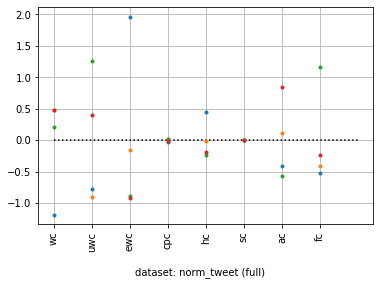

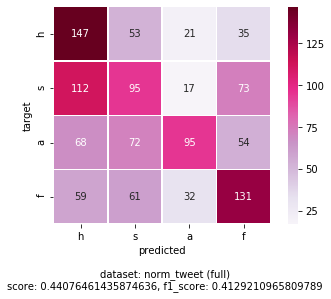

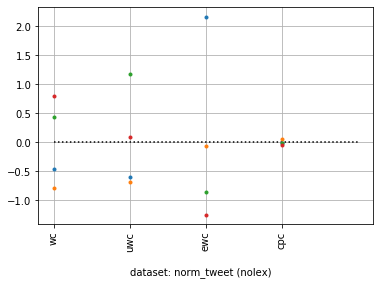

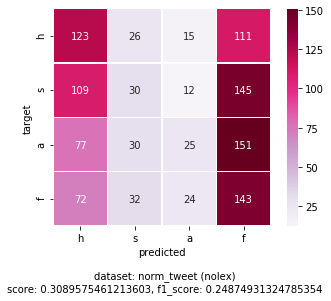

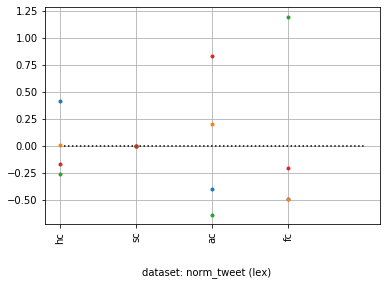

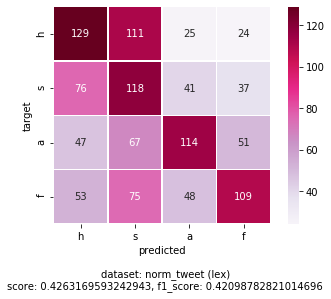

In [26]:
datasets = ["emotion", "norm_emotion", "tweet", "norm_tweet"]
features = {
    "full": ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "nolex": ["wc", "uwc", "ewc", "cpc"],
    "lex": ["hc", "sc", "ac", "fc"]
}
classes = ["happiness", "sadness", "anger", "fear"]
norm_emotion_full = ["wc", "ewc", "hc", "ac", "fc"]

all_results = []
coefficients = []

for dataset in ["norm_tweet"]: 
    for key, feature_set in features.items(): 
        results, coef = classify_with_lr(*load_lex_data(dataset, feature_set))
        all_results.append([dataset, key, *results])
        coefficients.append(coef)
    #results, coef = classify_with_lr(*load_vector_data(dataset))
    #all_results.append([dataset, "vec", *results])
    #coefficients.append(coef)

for index, result in enumerate(all_results): 
    with open("../img/report_lr_" + result[0] + "_"  + result[1] + ".txt", 'w') as f:
        print((result[0] + "_" + result[1] + " (" + str(result[5]) + "):\n" + 
          classification_report(result[2], result[3],target_names=classes)), file=f)
    draw_coefficients_plot(result[0], result[1], coefficients[index])
    draw_confusion_matrix(*result)